#Final Project: Assessing Air Quality and its Predictors Across the United States

###Group members: Elizabether Cheever, Mark Chaffin, & Nicole Lee

#Table of Contents
* [Background](#Background)
	* [Data Sources](#Data-Sources)
* [Data Cleaning](#Data-Cleaning)


#Background

##Measures of Air Quality

##Data Sources

Data used for this project came from a variety of different resources. The four main types of information collected were:
1. Air Quality Data
2. Weather Data
3. Demographic Data
4. Transport Data

**Air Quality Data**<br>
Our primary objective is to assess air quality in cities across the US. Air quality data was gathered from the EPA website http://aqsdr1.epa.gov/aqsweb/aqstmp/airdata/download_files.html. There is a separate file, for a separate pollutant, for each year from 1990 - 2015. For this analysis, we've focused on the 2010 data as it seemed most complete and we could find matching US census data for that year. We were interested in the main pollutants which are PM2.5, PM10, CO, NO2, SO2, and Ozone. These files were all csv formatted and we cleaned these data to get our final dataset. Data are collected at the daily level, so averages were taken at the monthly, seasonal, and yearly level.

For validation, European Air Quality Data can be gathered from http://www.eea.europa.eu/data-and-maps/data/. For this analysis, we will only be looking at Germany Data to keep the things more compact. There are many forms of this data, including raw daily files from a large range of years. For simiplicity, we are starting with the annual summary data from 2010.

**Weather Data**<br>
While there are many possible sources of weather data, there is a good starting point at the same EPA site listed above. The data has the same format as the pollutant data in that there is a separate file for each type of meterological data for each year. Again, we've downloaded the 2010 data and cleaned that by taking the average reading of each element for each day. Then we took an average of those average values over a given time period -- either season, month, or year.

European weather data can be obtained from ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/. There is data for many cities across the world found here so there is a lot of cleaning to be done.

**Demographic Data**<br>
We can collect CBSA demographic data like population size and population density fom the US census at: http://www.census.gov/population/metro/data/pop_data.html. This includes more information about what areas fall in each CBSA as well as basic population statistics. These data are from 2010 and will therefore be consistent with the Air Quality Data.

European demographic data can be obtained from Wikipedia by scraping the relevant cities' entries. This has been the approach employed here.

**Transport Data**<br>
US commuter transport data can be obtained for 2009-2013 at http://www.census.gov/hhes/commuting/. While the year does not line up perfectly with the other datasets, it is close and probably fairly comparable. For this data, we have subset the data to get counts and fractions of people commuting *into* each particular region daily. This should give a general feel for how commuting in the particular region works.

European transit data can be obtained from: http://epomm.eu/tems/. While German transit data spans 1994-2013, the average year is around 2007. By filtering out particularly old data (prior to 2005) the transit data should be fairly comparable in time scale to the other data collected.


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', -1)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import csv
import urllib
import time

#Data Cleaning

###United States Data

####Air Quality and Weather Data Collection

Here we must first read in several different csv files, one for each pollutant and one for each weather measurement. Before we do that, we define a couple helper functions to assign season and month to individual daily data entries.

In [5]:
#Function to get seasonal breadowns. Takes in
#a row from one of these csvs and splits the date
#column converting it to a datetime.
import datetime
def seasonMaker(rowIn):
    listeddate=[int(x) for x in rowIn.split("-")]
    dateInd = datetime.date(listeddate[0],listeddate[1],listeddate[2])
    if (dateInd <= datetime.date(2010,3,20)) or (dateInd >= datetime.date(2010,12,21)):
        return 'Winter'
    elif (dateInd <= datetime.date(2010,6,21)) and (dateInd >= datetime.date(2010,3,21)):
        return 'Spring'
    elif (dateInd <= datetime.date(2010,9,21)) and (dateInd >= datetime.date(2010,6,22)):
        return 'Summer'
    elif (dateInd <= datetime.date(2010,12,20)) and (dateInd >= datetime.date(2010,9,22)):
        return 'Fall'

In [6]:
#A similar function to the above, but it assigns month rather than season
def monthMaker(rowIn):
    listeddate=[int(x) for x in rowIn.split("-")]
    return listeddate[1]

We now read in all the weather and pollutant data for the US, starting with PM2.5_frmfem. We need to make our base dataframe first and will use this particular csv to do so. We want to make 3 dataframes from all this, `SeasonDat`, `YearDat`, and `MonthDat`. These represent the different aggregations of pollution and weather data. Daily observations are too variable to get an overall image without some aggregation.

**Read in all US air quality files**

In [4]:
#Read in each file one-by-one and add a variable to denote season and one to denote month
#PM2.5_frmfem
pm25_frmfem = pd.read_csv("tempdata/pm2.5frmfem_2010.csv")
pm25_frmfem['season']=pm25_frmfem.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
pm25_frmfem['month']=pm25_frmfem.apply(lambda row: monthMaker(row['Date Local']), axis=1)
#PM2.5_no_frmfem
pm25_nofrmfem = pd.read_csv("tempdata/pm2.5_non_frmfem_2010.csv")
pm25_nofrmfem['season']=pm25_nofrmfem.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
pm25_nofrmfem['month']=pm25_nofrmfem.apply(lambda row: monthMaker(row['Date Local']), axis=1)
#PM10
pm10 = pd.read_csv("tempdata/pm10_2010.csv")
pm10['season']=pm10.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
pm10['month']=pm10.apply(lambda row: monthMaker(row['Date Local']), axis=1)
#TEMP
temp = pd.read_csv("tempdata/temp_2010.csv")
temp['season']=temp.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
temp['month']=temp.apply(lambda row: monthMaker(row['Date Local']), axis=1)
#PRESS
press = pd.read_csv("tempdata/press_2010.csv")
press['season']=press.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
press['month']=press.apply(lambda row: monthMaker(row['Date Local']), axis=1)
#RH_DP
rh_dp = pd.read_csv("tempdata/rh_dp_2010.csv")
rh_dp['season']=rh_dp.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
rh_dp['month']=rh_dp.apply(lambda row: monthMaker(row['Date Local']), axis=1)
rh = rh_dp[rh_dp['Parameter Name']=='Relative Humidity ']
dp = rh_dp[rh_dp['Parameter Name']=='Dew Point']
#WIND
wind = pd.read_csv("tempdata/wind_2010.csv")
wind['season']=wind.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
wind['month']=wind.apply(lambda row: monthMaker(row['Date Local']), axis=1)
wind = wind[wind['Units of Measure']=='Knots']
#CO
co = pd.read_csv("tempdata/co_2010.csv")
co['season']=co.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
co['month']=co.apply(lambda row: monthMaker(row['Date Local']), axis=1)
co = co[co['Pollutant Standard']=='CO 8-hour 1971']
#NO2
no2 = pd.read_csv("tempdata/no2_2010.csv")
no2['season']=no2.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
no2['month']=no2.apply(lambda row: monthMaker(row['Date Local']), axis=1)
#OZONE
ozone = pd.read_csv("tempdata/ozone_2010.csv")
ozone['season']=ozone.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
ozone['month']=ozone.apply(lambda row: monthMaker(row['Date Local']), axis=1)
#SO2
so2 = pd.read_csv("tempdata/so2_2010.csv")
so2['season']=so2.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
so2['month']=so2.apply(lambda row: monthMaker(row['Date Local']), axis=1)
so2 = so2[so2['Pollutant Standard']=='SO2 1-hour 2010']

Get all the possible Core-Based Statistical Areas (CBSA). These are used for census data of all areas connected to a metropolitan area or micropolitan area. We will use these as a unit of observation because sites in the same CBSA will likely have very similar pollutant and weather measurements.

In [5]:
fileList = [pm25_frmfem,pm25_nofrmfem,pm10,temp,press,rh,dp,wind,co,no2,ozone,so2]
uniqueCBSA = np.array([])
for f in fileList:
    uniqueCBSA= np.append(uniqueCBSA,f['CBSA Name'].unique())
uniqueCBSA = set(uniqueCBSA)
print "Number of unique CBSA in all files: "+str(len(uniqueCBSA))

Number of unique CBSA in all files: 534


What about the ones that didn't have a CBSA identifier? How many were there and what Site Location were they?

In [6]:
numDup = pd.DataFrame(columns=['Local Site Name','State Name','County Name','City Name'])
for f in fileList:
    a=f[pd.isnull(f['CBSA Name'])]
    names = a.ix[:,['Local Site Name','State Name','County Name','City Name']]
    names = names.drop_duplicates()
    numDup = pd.concat([numDup,names])
print "Number of Sites with no CBSA: " +str(len(numDup.drop_duplicates()))

Number of Sites with no CBSA: 308


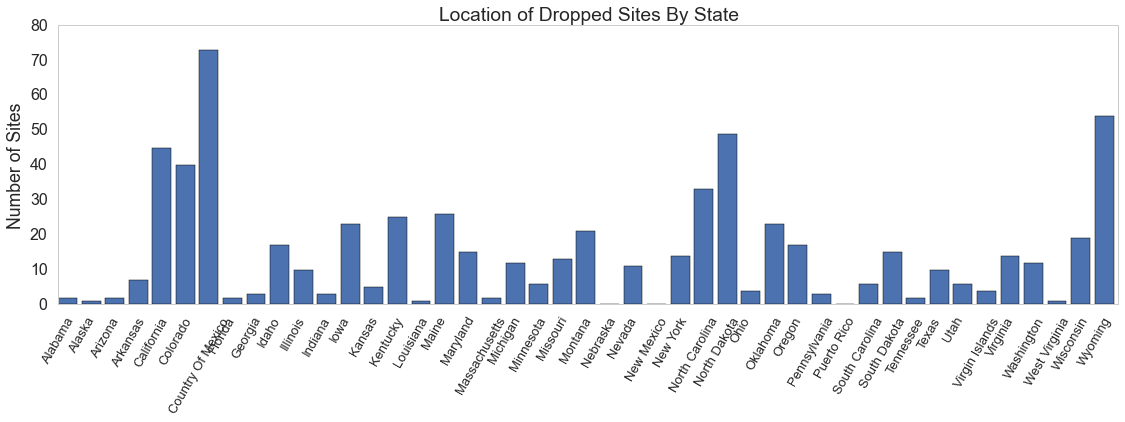

In [7]:
group = numDup.groupby('State Name')
f,ax = plt.subplots(figsize=(19,5))
ax.bar(range(len(group)),group.count()['Local Site Name'])
ax.set_xticks(range(len(group)))
ax.grid(False)
ax.set_xticklabels(group.count().index,rotation=60,size=13,ha='center')
ax.set_title('Location of Dropped Sites By State')
ax.set_ylabel('Number of Sites')
plt.show()

There are some states that have more dropped sites than others. There seems to be slight bias in the more rural areas -- this makes sense at CBSA assignments are for metropolitan and micropolitan areas. The state that loses the most sites is actually the Country of Mexico which we'd probably like to exclude anyway given that we are interested in the US.

####Collecting Demographics

We will proceed with just the sites that fall in a particular CBSA. This allows interpretation and data compiling a bit easier without a large loss of information.

Next we'd like to be able to pull population density information and other info in for these CBSA ids. This requires another data set from http://www.census.gov/population/metro/data/pop_data.html. This data is from 2010, but even though we're looking at 2014 weather/air quality data, it shouldn't have changed too dramatically in 4 years.

In [11]:
densityFile = pd.read_csv('tempdata/CBSA_density.csv')

In [12]:
#Removing top bad rows (just nonsense), removing bad columns, renaming columns
densityFile.drop(densityFile.index[[0,1,2,3,4,5,6,7]],inplace=True)
densityFile.drop(densityFile.columns[[3,6,8,10]],axis=1,inplace=True)
densityFile.columns=['id','name','MetArea','pop2010','landarea','popdense2010','pop_weight2010']

In [13]:
densityFile.head()

,id,name,MetArea,pop2010,landarea,popdense2010,pop_weight2010
8,10180,"Abilene, TX",Metropolitan Statistical Area,"165,252","2,743.5",60.2,"1,771.8"
9,10420,"Akron, OH",Metropolitan Statistical Area,"703,200",900.1,781.2,"2,412.8"
10,10500,"Albany, GA",Metropolitan Statistical Area,"157,308","1,932.6",81.4,922.7
11,10580,"Albany-Schenectady-Troy, NY",Metropolitan Statistical Area,"870,716","2,811.6",309.7,"2,944.9"
12,10740,"Albuquerque, NM",Metropolitan Statistical Area,"887,077","9,282.5",95.6,"3,518.6"


This next file has the latitude and longitude data we'll want to use for each region. We need to merge this all together in case we need to do mapping later.

In [14]:
latlong = pd.read_csv('tempdata/CBSA_Chapter1PrinCities.csv')

This file has a lot of problems in the way information is provided. We want info for just the individual regions but there are a lot of NaNs. This is because only the primary city of a region gets the label. So we need to clean that up a bit. 

In [15]:
#Removing top bad rows, removing bad columns, renaming columns
latlong.drop(latlong.index[[0,1,2,3,4]],inplace=True)
latlong.drop(latlong.columns[[1,4]],axis=1,inplace=True)
latlong.columns=['id','name','pop2010','latitude','longitude']

In [16]:
#Get latitude and longitude for each id
group = latlong.groupby('id')
#Get rid of all the NaNs
#Help from 
#http://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-of-certain-column-is-nan
newdf=group.max()
newdf = newdf[pd.notnull(newdf['latitude'])]
#Weird anomaly
newdf.drop(newdf.index[6],inplace=True)

In [17]:
newdf['id']=newdf.index
newdf.head()

,name,pop2010,latitude,longitude,id
id,,,,,
10180,"Abilene, TX Metro Area","165,252",32.4519790,-99.7327870,10180
10420,"Akron, OH Metro Area","703,200",41.0805750,-81.5180690,10420
10500,"Albany, GA Metro Area","77,434",31.5783550,-84.1525160,10500
10580,Troy city,"97,856",42.6517310,-73.7551670,10580
10740,"Albuquerque, NM Metro Area","887,077",35.0879680,-106.6504030,10740


For merging purposes, we need to get a unique mapper between all the files. It's easiest to link all the different names of the CBSA's with a particular numerical ID that exists in these last two files. We spend a bit of time here setting those up to save work later.

In [19]:
#Make a mapper to get numerical id for CBSA
idmapper = {}
for id, name in zip(densityFile.id,densityFile.name):
    idmapper[name]=id

In [20]:
#Set up the dictionary base
#The first entry in uniqueCBSA is NaN so we want
#to remove that
myFrame = pd.DataFrame({'name':list(uniqueCBSA)[1:]})
#Add numerical label 
myFrame['id']=myFrame['name'].map(idmapper.get)
myFrame.head()

,name,id
0,"Kahului-Wailuku, HI",27980
1,"Rapid City, SD",39660
2,"Seymour, IN",42980
3,"Fort Wayne, IN",23060
4,"Bend, OR",13460


Some CBSA's didn't map to a particular numerical ID. This is because the CBSA namings have changed over time. It's painful, but probably easiest, to manually fix these 23 issues.

In [21]:
#Deal with missing numerical labels case-by-case...
#Painful, but doable
a = myFrame[pd.isnull(myFrame['id'])]
print "Number of cities without numerical ID match: "+str(len(a))
a

Number of cities without numerical ID match: 23


,name,id
17,"Wenatchee, WA",None
28,"Bakersfield, CA",None
39,"San Antonio, TX",None
51,"Portland-Vancouver-Beaverton, OR-WA",None
68,"Myrtle Beach-Conway-North Myrtle Beach, SC",None
115,"Bradenton-Sarasota-Venice, FL",None
118,"Madera, CA",None
122,"Atlantic City, NJ",None
149,"Weirton-Steubenville, WV-OH",None
155,"Chicago-Naperville-Joliet, IL-IN-WI",None


In [22]:
#This dictionary has the name in myFrame and then the new name we need to use to map to the numerical ID as the value
badmatch = {'Wenatchee, WA':'Wenatchee-East Wenatchee, WA','San Antonio, TX':'San Antonio-New Braunfels, TX',
           'Portland-Vancouver-Beaverton, OR-WA':'Portland-Vancouver-Hillsboro, OR-WA','Bradenton-Sarasota-Venice, FL':'North Port-Bradenton-Sarasota, FL',
           'Madera, CA':'Madera-Chowchilla, CA','Atlantic City, NJ':'Atlantic City-Hammonton, NJ','Weirton-Steubenville, WV-OH':'Steubenville-Weirton, OH-WV',
           'Chicago-Naperville-Joliet, IL-IN-WI':'Chicago-Joliet-Naperville, IL-IN-WI','Bakersfield, CA':'Bakersfield-Delano, CA',
           'Durham, NC':'Durham-Chapel Hill, NC','Mayaguez, PR':'Mayag\xfcez, PR','Kennewick-Richland-Pasco, WA':'Kennewick-Pasco-Richland, WA',
           'Canon City, CO':'Ca\xf1on City, CO','Lakeland, FL':'Lakeland-Winter Haven, FL','Orlando-Kissimmee, FL':'Orlando-Kissimmee-Sanford, FL',
           'Phoenix-Mesa-Scottsdale, AZ':'Phoenix-Mesa-Glendale, AZ','Nashville-Davidson-Murfreesboro-Franklin, TN':'Nashville-Davidson--Murfreesboro--Franklin, TN',
           'Charlotte-Gastonia-Concord, NC-SC':'Charlotte-Gastonia-Rock Hill, NC-SC','Washington Court House, OH, AR':'Washington Court House, OH',
           'Panama City-Lynn Haven, FL':'Panama City-Lynn Haven-Panama City Beach, FL','Fort Walton Beach-Crestview-Destin, FL':'Crestview-Fort Walton Beach-Destin, FL',
           'Austin-Round Rock, TX':'Austin-Round Rock-San Marcos, TX','Charleston-North Charleston, SC':'Charleston-North Charleston-Summerville, SC',
           'Denver-Aurora, CO':'Denver-Aurora-Broomfield, CO','Myrtle Beach-Conway-North Myrtle Beach, SC':'Myrtle Beach-North Myrtle Beach-Conway, SC'}

In [23]:
#We need to reverse this dictionary for use later as well
reverse_bad = {v: k for k, v in badmatch.items()}
for id, name in zip(densityFile.id,densityFile.name):
    if name in badmatch.values():
        idmapper[reverse_bad[name]]=id

In [24]:
#Make a copy of the mapper to use in the rest of the data
idmapper2 = idmapper.copy()

In [25]:
#Rerun the mapping afresh
myFrame = pd.DataFrame({'name':list(uniqueCBSA)[1:]})
#Add numerical label 
myFrame['id']=myFrame['name'].map(idmapper2.get)
myFrame.head()

,name,id
0,"Kahului-Wailuku, HI",27980
1,"Rapid City, SD",39660
2,"Seymour, IN",42980
3,"Fort Wayne, IN",23060
4,"Bend, OR",13460


In [26]:
#Check the dataframe
a = myFrame[pd.isnull(myFrame['id'])]
print "Number of cities without numerical ID match: "+str(len(a))

Number of cities without numerical ID match: 0


We now have all our cities mapped to numerical IDs. Great! Now comes time to start merging things together. After these next few cells we are left with a dataframe with some information about each of the CBSAs.

In [27]:
myFrame.merge(newdf,on='id',how='left').head()

,name_x,id,name_y,pop2010,latitude,longitude
0,"Kahului-Wailuku, HI",27980,NaN,NaN,NaN,NaN
1,"Rapid City, SD",39660,"Rapid City, SD Metro Area","67,956",44.0830460,-103.2262970
2,"Seymour, IN",42980,NaN,NaN,NaN,NaN
3,"Fort Wayne, IN",23060,"Fort Wayne, IN Metro Area","416,257",41.0805560,-85.1391380
4,"Bend, OR",13460,"Bend, OR Metro Area","76,639",44.0573050,-121.3158290


In [28]:
#Add latitude longitude
intermediate = myFrame.merge(newdf,on='id',how='left')
intermediate.drop(intermediate.columns[2],axis=1,inplace=True)

In [29]:
#Add population density
DemoFrame = intermediate.merge(densityFile,on='id',how='left')
DemoFrame.drop(DemoFrame.columns[[0,2]],axis=1,inplace=True)
DemoFrame.columns=['id','latitude','longitude','name','MetArea','pop2010','landarea','popdense2010','pop_weight2010']
#Fix values that have commas like 1,049 and 1,170.8 so we can use them as floats later
a = [str(x) for x in list(DemoFrame['popdense2010'].values)]
b = [float(x.replace(",","")) for x in a]
DemoFrame['popdense2010']=b
a = [str(x) for x in list(DemoFrame['pop_weight2010'].values)]
b = [float(x.replace(",","")) for x in a]
DemoFrame['pop_weight2010']=b
a = [str(x) for x in list(DemoFrame['landarea'].values)]
b = [float(x.replace(",","")) for x in a]
DemoFrame['landarea']=b
a = [str(x) for x in list(DemoFrame['pop2010'].values)]
b = [float(x.replace(",","")) for x in a]
DemoFrame['pop2010']=b
#View the frame
DemoFrame.head()

,id,latitude,longitude,name,MetArea,pop2010,landarea,popdense2010,pop_weight2010
0,27980,NaN,NaN,"Kahului-Wailuku, HI",Micropolitan Statistical Area,154834,1161.5,133.3,2310.8
1,39660,44.0830460,-103.2262970,"Rapid City, SD",Metropolitan Statistical Area,126382,6247.5,20.2,1170.8
2,42980,NaN,NaN,"Seymour, IN",Micropolitan Statistical Area,42376,509.3,83.2,784.2
3,23060,41.0805560,-85.1391380,"Fort Wayne, IN",Metropolitan Statistical Area,416257,1361.0,305.9,1964.2
4,13460,44.0573050,-121.3158290,"Bend, OR",Metropolitan Statistical Area,157733,3018.2,52.3,1154.6


####Collecting Transit Data

Now we need to compile the traffic data to use. This comes from an excel file that is quite large -- we need to manipulate to collect the relevant pieces of information

In [30]:
#Load traffic excel file
trafDat = pd.read_excel('tempdata/census_commute_2009_2013.xlsx')

In [31]:
#Drop first several rows of excess info
trafDat.drop(trafDat.index[[0,1,2,3,4,5,6,106181,106182,106183,106184,106185]],inplace=True)

In [32]:
#Drop excess columns
trafDat.drop(trafDat.columns[[0,1,2,3,4,5,6,7]],axis=1,inplace=True)

In [33]:
#Rename remaing columns appropriately
trafDat.columns=['State','County','id','CBSA Name','Travel Mode','NumComm','MOE']

In [34]:
#Group by the id (numerical CBSA id) and the travel mode
#Get sum of people commuting into each CBSA by each travel
#mode
group = trafDat.groupby(['id','Travel Mode'])
a = pd.DataFrame(group.sum()['NumComm'])
trafDatClean = a.reset_index()

In [35]:
trafDatClean.head()

,id,Travel Mode,NumComm
0,10180,"Car, truck, or van: Carpooled",8489
1,10180,"Car, truck, or van: Drove alone",57771
2,10180,Other travel mode,5130
3,10180,Public transportation,450
4,10260,"Car, truck, or van: Carpooled",263


In [36]:
uniqueTraf = trafDatClean['id'].unique()

In [37]:
#Get ids that are in the demo and air data
airDatID = []
for i in idmapper2.values():
    if str(i) == 'nan':
        continue
    else:
        airDatID.append(int(i))
        
goods = []
bads = []
for i in uniqueTraf:
    if i in airDatID:
        goods.append(i)
    else:
        bads.append(i)

In [38]:
print 'Number of Traffic Locations in Other Data: '+str(len(goods))
print 'Number of Traffic Locations NOT in Other Data: '+str(len(bads))

Number of Traffic Locations in Other Data: 384
Number of Traffic Locations NOT in Other Data: 9


The vast majority of cities with traffic data also are found in the air quality data which is great! There are a few ids that are not in our air quality data. We can take a look at what those cities are here.

In [52]:
for i in bads:
    a = trafDat[trafDat['id']==i]
    print a['CBSA Name'].unique()

[u'Arecibo, PR']
[u'Bloomington, IL ']
[u'California-Lexington Park, MD ']
[u'Coco, PR']
[u'Lafayette-West Lafayette, IN ']
[u'Los Angeles-Long Beach-Anaheim, CA ']
[u'Santa Maria-Santa Barbara, CA ']
[u'Urban Honolulu, HI ']
[u'Weirton-Steubenville, WV-OH ']


There doesn't seem to be any systematic difference here so we will just assume we don't have air quality data for these cities, so they're not of interest because we can't make predictions. Therefore they will just be dropped.

The next code is a bit of cleaning to get a dataframe that we can merge with our other data. Right now we just have overall numbers of commuters into each region. We'd like to get fractional breakdowns of commuters by type so we calculate the below.

In [39]:
#Generate a dataframe of the traffic data for merging
#Specify the columns to be used
outDict = {'total_trans':[],'carpool':[],'alone':[],'other':[],'pt':[],'carpool_frac':[],
          'alone_frac':[],'other_frac':[],'pt_frac':[]}
#Keep track of the index
index = []

#Loop through all the cities in the traffic file
for i in trafDatClean['id'].unique():
    #Subset to the specific city
    a = trafDatClean[trafDatClean['id']==i]
    #Get the counts
    total = int(a['NumComm'].sum())
    carpool = int(a[a['Travel Mode']=='Car, truck, or van: Carpooled']['NumComm'])
    alone = int(a[a['Travel Mode']=='Car, truck, or van: Drove alone']['NumComm'])
    other = int(a[a['Travel Mode']=='Other travel mode']['NumComm'])
    pt = int(a[a['Travel Mode']=='Public transportation']['NumComm'])
    #Get the fractions
    carpool_frac = float(carpool)/float(total)
    alone_frac = float(alone)/float(total)
    other_frac = float(other)/float(total)
    pt_frac = float(pt)/float(total)
    #Append relevant information
    index.append(i)
    outDict['total_trans'].append(total)
    outDict['carpool'].append(carpool)
    outDict['alone'].append(alone)
    outDict['other'].append(other)
    outDict['pt'].append(pt)
    outDict['carpool_frac'].append(carpool_frac)
    outDict['alone_frac'].append(alone_frac)
    outDict['other_frac'].append(other_frac)
    outDict['pt_frac'].append(pt_frac)
#Return dataframe
trafDatCompiled = pd.DataFrame(outDict,index=index)
trafDatCompiled['id']=trafDatCompiled.index

####Merging Demographics, Air Quality, Weather, and Transit Data

What we need to do here is aggregate information across all these files -- traffic, demographics, weather, and air quality. The weather and air quality data is still stored *daily* information. So that's the first challenge. We will work with just the average daily readings to begin with (we could have looked at max readings, but that may not be as informative as an overall metric). Then we want to aggreate daily measurements at a location to average monthly readings. average seasonal readings, and average yearly readings. This may not be the *most* robust strategy, but it will hopefully give a good starting point to investiage trends.

In [40]:
#DOING SEASONAL AVERAGING FIRST
fileList = [pm25_frmfem,pm25_nofrmfem,pm10,temp,press,rh,dp,wind,co,no2,ozone,so2]
fileName = ['PM25_FRMFEM','PM25_NOFRMFEM','PM10','TEMP','PRESS','RH','DP','WIND','CO','NO2','OZONE','SO2']
count = 0
for f,n in zip(fileList,fileName):
    if count == 0:
        group = f.groupby(['CBSA Name','season'])
        means = group.mean()
        means.drop(means.columns[[0,1,2,3,4,7,8,10,11,13]],axis=1,inplace=True)
        means.reset_index()
        means.reset_index(inplace=True)
        means.rename(columns={ 'Arithmetic Mean' : n,'AQI' : 'AQI_'+n},inplace=True)
    else:
        group = f.groupby(['CBSA Name','season'])
        toAdd = group.mean()
        toAdd = pd.DataFrame(toAdd, columns=['Arithmetic Mean','AQI'])
        toAdd.reset_index()
        toAdd.reset_index(inplace=True)
        toAdd.rename(columns={ 'Arithmetic Mean' : n,'AQI' : 'AQI_'+n},inplace=True)
        means = pd.merge(means,toAdd.reset_index(),on=['CBSA Name','season'],how='outer').reset_index()
        means.drop(['level_0','index'],axis=1,inplace=True)
    count += 1
means.drop(['month'],axis=1,inplace=True)

In [41]:
means['id']=means['CBSA Name'].map(idmapper2.get)

In [42]:
SeasonDat = means[means['id'].isin(myFrame['id'])]

In [43]:
SeasonDat.shape

(2105, 29)

In [44]:
print "# of Cities with Winter Data: "+str(SeasonDat[SeasonDat['season']=='Winter'].shape[0])
print "# of Cities with Summer Data: "+str(SeasonDat[SeasonDat['season']=='Summer'].shape[0])
print "# of Cities with Spring Data: "+str(SeasonDat[SeasonDat['season']=='Spring'].shape[0])
print "# of Cities with Fall Data: "+str(SeasonDat[SeasonDat['season']=='Fall'].shape[0])

# of Cities with Winter Data: 516
# of Cities with Summer Data: 529
# of Cities with Spring Data: 531
# of Cities with Fall Data: 529


In [45]:
#DOING MONTHLY AVERAGING SECOND
fileList = [pm25_frmfem,pm25_nofrmfem,pm10,temp,press,rh,dp,wind,co,no2,ozone,so2]
fileName = ['PM25_FRMFEM','PM25_NOFRMFEM','PM10','TEMP','PRESS','RH','DP','WIND','CO','NO2','OZONE','SO2']
count = 0
for f,n in zip(fileList,fileName):
    if count == 0:
        group = f.groupby(['CBSA Name','month'])
        means = group.mean()
        means.drop(means.columns[[0,1,2,3,4,7,8,10,11,13]],axis=1,inplace=True)
        means.reset_index()
        means.reset_index(inplace=True)
        means.rename(columns={ 'Arithmetic Mean' : n,'AQI' : 'AQI_'+n},inplace=True)
    else:
        group = f.groupby(['CBSA Name','month'])
        toAdd = group.mean()
        toAdd = pd.DataFrame(toAdd, columns=['Arithmetic Mean','AQI'])
        toAdd.reset_index()
        toAdd.reset_index(inplace=True)
        toAdd.rename(columns={ 'Arithmetic Mean' : n,'AQI' : 'AQI_'+n},inplace=True)
        means = pd.merge(means,toAdd.reset_index(),on=['CBSA Name','month'],how='outer').reset_index()
        means.drop(['level_0','index'],axis=1,inplace=True)
    count += 1
means['id']=means['CBSA Name'].map(idmapper2.get)
MonthDat = means[means['id'].isin(myFrame['id'])]
MonthDat.shape

(6239, 29)

In [46]:
print "# of Cities with January Data: "+str(MonthDat[MonthDat['month']==1].shape[0])
print "# of Cities with February Data: "+str(MonthDat[MonthDat['month']==2].shape[0])
print "# of Cities with March Data: "+str(MonthDat[MonthDat['month']==3].shape[0])
print "# of Cities with April Data: "+str(MonthDat[MonthDat['month']==4].shape[0])
print "# of Cities with May Data: "+str(MonthDat[MonthDat['month']==5].shape[0])
print "# of Cities with June Data: "+str(MonthDat[MonthDat['month']==6].shape[0])
print "# of Cities with July Data: "+str(MonthDat[MonthDat['month']==7].shape[0])
print "# of Cities with August Data: "+str(MonthDat[MonthDat['month']==8].shape[0])
print "# of Cities with September Data: "+str(MonthDat[MonthDat['month']==9].shape[0])
print "# of Cities with October Data: "+str(MonthDat[MonthDat['month']==10].shape[0])
print "# of Cities with November Data: "+str(MonthDat[MonthDat['month']==11].shape[0])
print "# of Cities with December Data: "+str(MonthDat[MonthDat['month']==12].shape[0])

# of Cities with January Data: 505
# of Cities with February Data: 508
# of Cities with March Data: 526
# of Cities with April Data: 529
# of Cities with May Data: 529
# of Cities with June Data: 529
# of Cities with July Data: 529
# of Cities with August Data: 529
# of Cities with September Data: 529
# of Cities with October Data: 523
# of Cities with November Data: 502
# of Cities with December Data: 501


In [47]:
#DOING YEARLY AVERAGING THIRD
fileList = [pm25_frmfem,pm25_nofrmfem,pm10,temp,press,rh,dp,wind,co,no2,ozone,so2]
fileName = ['PM25_FRMFEM','PM25_NOFRMFEM','PM10','TEMP','PRESS','RH','DP','WIND','CO','NO2','OZONE','SO2']
count = 0
for f,n in zip(fileList,fileName):
    if count == 0:
        group = f.groupby(['CBSA Name'])
        means = group.mean()
        means.drop(means.columns[[0,1,2,3,4,7,8,10,11,13,14]],axis=1,inplace=True)
        means.reset_index()
        means.reset_index(inplace=True)
        means.rename(columns={ 'Arithmetic Mean' : n,'AQI' : 'AQI_'+n},inplace=True)
    else:
        group = f.groupby(['CBSA Name'])
        toAdd = group.mean()
        toAdd = pd.DataFrame(toAdd, columns=['Arithmetic Mean','AQI'])
        toAdd.reset_index()
        toAdd.reset_index(inplace=True)
        toAdd.rename(columns={ 'Arithmetic Mean' : n,'AQI' : 'AQI_'+n},inplace=True)
        means = pd.merge(means,toAdd.reset_index(),on=['CBSA Name'],how='outer').reset_index()
        means.drop(['level_0','index'],axis=1,inplace=True)
    count += 1
means['id']=means['CBSA Name'].map(idmapper2.get)
YearDat = means[means['id'].isin(myFrame['id'])]
YearDat.shape

(533, 28)

In [48]:
#Merge in demographic info
SeasonDat = SeasonDat.merge(DemoFrame[['id','MetArea','pop2010','landarea','popdense2010','pop_weight2010']],on='id',how='left')
MonthDat = MonthDat.merge(DemoFrame[['id','MetArea','pop2010','landarea','popdense2010','pop_weight2010']],on='id',how='left')
YearDat = YearDat.merge(DemoFrame[['id','MetArea','pop2010','landarea','popdense2010','pop_weight2010']],on='id',how='left')

In [49]:
trafDatCompiled.head()

,alone,alone_frac,carpool,carpool_frac,other,other_frac,pt,pt_frac,total_trans,id
10180,57771,0.804162,8489,0.118165,5130,0.071409,450,0.006264,71840,10180
10260,1988,0.759648,263,0.100497,359,0.137180,7,0.002675,2617,10260
10380,56397,0.835486,5157,0.076398,5625,0.083331,323,0.004785,67502,10380
10420,279452,0.862533,21925,0.067672,18393,0.056770,4220,0.013025,323990,10420
10500,46696,0.794907,7895,0.134397,3525,0.060006,628,0.010690,58744,10500


Now we have the weather and air quality data together in an individual file each. We next just need to merge in the demographic and traffic data and we'll be good to go!

In [51]:
#Covert ids to int for easier merging with traffic data
SeasonDat['id']=SeasonDat['id'].astype(int)
YearDat['id']=YearDat['id'].astype(int)
MonthDat['id']=MonthDat['id'].astype(int)

In [52]:
#Merge in traffic data
SeasonDat = SeasonDat.merge(trafDatCompiled,on='id',how='left')
MonthDat = MonthDat.merge(trafDatCompiled,on='id',how='left')
YearDat = YearDat.merge(trafDatCompiled,on='id',how='left')

In [53]:
#Remove a few nonsensical columns that are all NAs
MonthDat.drop(['AQI_TEMP','AQI_PRESS','AQI_RH','AQI_DP','AQI_WIND'],axis=1,inplace=True)
SeasonDat.drop(['AQI_TEMP','AQI_PRESS','AQI_RH','AQI_DP','AQI_WIND'],axis=1,inplace=True)
YearDat.drop(['AQI_TEMP','AQI_PRESS','AQI_RH','AQI_DP','AQI_WIND'],axis=1,inplace=True)

In [54]:
#Save the cleaned dataframe to file
MonthDat.to_csv("MonthDat.csv",index=False,na_rep='NA')
YearDat.to_csv("YearDat.csv",index=False,na_rep='NA')
SeasonDat.to_csv("SeasonDat.csv",index=False,na_rep='NA')

All these datasets have a straightforward labeling convention. The scheme is laid out below.

In [55]:
import collections
varlab={'CBSA Name':'Core-Based Statistical Area Name','Month/Season':'This respective variable will be in the Month or Season dataset indicating the month or year the data is from',
                'Latitude':'The average latitude of all sites in the CBSA for the given time period','Longitude':'The average longitude of all sites in the CBSA for a given time period',
                'PM25_FRMFEM':'Average level of particulate matter up to 2.5 micrometers based on Federal Reference Method or Federal Equivalent Method in given time period (Micrograms/cubic meter (LC))',
                'AQI_PM25_FRMFEM':'Average Air Quality Index of Particulate Matter up to 2.5 micrometers in given time period',
                'PM25_NOFRMFEM':'Average level of particulate matter up to 2.5 micrometers NOT based on Federal Reference Method or Federal Equivalent Method in given time period (Micrograms/cubic meter (LC))',
                'AQI_PM25_NOFRMFEM':'Average Air Quality Index of Particulate Matter of up to 2.5 micrometers NOT based on Federal Reference Method or Federal Equivalent Method',
                'PM10':'Average Particulate Matter up to 10 micrometers in given time period (Microgram/cubic meter (25 C))',
                'AQ_PM10':'Average Air Quality Index of Particulate Matter of up to 10 micrometers in given time period',
                'TEMP':'Average Temperature over time period (F)','PRESS':'Average Air Pressure over time period (Millibars)',
                'RH':'Average Relative Humidity over time period (percent  relative humidity)','DP':'Dewpoint over time period (F)',
                'WIND':'Average wind speed (Knots)','CO':'Average CO levels over time period (ppm)','AQI_CO':"Average Air Quality Index of CO over time period",
                'NO2':'Average NO2 levels over time period (ppb)','AQI_NO2':'Average Air Quality Index of NO2 over time period (ppb)',
                'OZONE':'Average ozone levels (O3) over time period (ppm)','AQI_OZONE':'Average Air Quality Index of Ozone over time period',
                'SO2':"Average SO2 levels over time period (ppb)",'AQI_SO2':'Average AQI of SO2 over time period',
                'id':'Numerical ID of Core-Based Statistical Area','MetArea':'An indicator of whether the site is a Metropolitan or Micropolitan Area',
                'pop2010':'The population size of the CBA in 2010','landarea':'The size of the CBSA (square miles)',
                'popdense2010':'The population density of CBSA in 2010','pop_weight2010':'Population weighted density in 2010 of CBSA',
       'alone':'Number of individuals commuting into this region alone daily - 2010','alone_frac':'Fraction of individuals commuting into this region alone daily - 2010',
       'carpool':'Number of individuals commuting into this region in carpool daily - 2010','carpool_frac':'Fraction of individuals commuting into this region in carpool daily - 2010',
       'other':'Number of individuals commuting into this region by bike, walk, or other daily - 2010','other_frac':'Fraction of individuals commuting into this region via bike, walk, or other daily - 2010',
       'pt':'Number of individuals commuting into this region via public transit daily - 2010','pt_frac':'Fraction of individuals commuting into this region via public transit daily - 2010',
       'total':'Total number of individuals commuting in the region daily - 2010'}
a = collections.OrderedDict(sorted(varlab.items()))
out = pd.DataFrame(a.items(),columns=['Variable Name','Definition'])
print "Codebook for datasets:"
out

Codebook for datasets:


,Variable Name,Definition
0,AQI_CO,Average Air Quality Index of CO over time period
1,AQI_NO2,Average Air Quality Index of NO2 over time period (ppb)
2,AQI_OZONE,Average Air Quality Index of Ozone over time period
3,AQI_PM25_FRMFEM,Average Air Quality Index of Particulate Matter up to 2.5 micrometers in given time period
4,AQI_PM25_NOFRMFEM,Average Air Quality Index of Particulate Matter of up to 2.5 micrometers NOT based on Federal Reference Method or Federal Equivalent Method
5,AQI_SO2,Average AQI of SO2 over time period
6,AQ_PM10,Average Air Quality Index of Particulate Matter of up to 10 micrometers in given time period
7,CBSA Name,Core-Based Statistical Area Name
8,CO,Average CO levels over time period (ppm)
9,DP,Dewpoint over time period (F)


###Germany Data

For validation, we'd like to work with German city data. These cities are likely fairly comparable to lots of the US climatically and is an equally developed country. There are other choices we could have made but it seems like a decent country to make a comparison to.

####Collecting Air Quality Data

Now that we have our main data source of US air quality, weather, demographic, and transit data, we similarly want to create files for German cities to validate our analysis on. We cannot get this information from the EPA or US Census Data so we need to spend some time collecting this from various sources. The next several steps will involve collecting and cleaning this data. We will start with just pooling the yearly data as this is in a easier to access format. Not all the formats and years are 100% comparable with the US data, but it seems pretty close in most measures.

In [66]:
#Read in the German air quality summary file
#This is a large file that needs a fair amount of cleaning
#It has all the same pollutants we looked at with the US
GermanAir = pd.read_csv('tempdata/AirBase_DE_v8_statistics.csv',sep='\t')

In [67]:
#Read in German Air Measurement Station Data
#This includes info about each site
stationInfo = pd.read_csv('tempdata/AirBase_DE_v8_stations.csv',sep='\t')

In [68]:
#Make a map of German Station City to
#German Station code
mapCityID = {}
for i,j in zip(stationInfo['station_european_code'],stationInfo['station_city']):
    mapCityID[i] = j
#Also make a reverse map as we will need that as well
revmapCityID = {v: k for k, v in mapCityID.items()}

In [69]:
#Filter to yearly measurements from 2010 first
GermanAir = GermanAir[GermanAir['statistics_year']==2012]

In [56]:
#Manually created a mapping of the different cities
#that have both traffic and air quality data
#This was done by looking at the city names and seeing
#which appear in both. In total there were 81 cities which
#seems like a decent size validation set
traffic_air_map_germany = {'AACHEN':'Aachen','AUGSBURG':'Augsburg','BAMBERG':'Bamberg','BERLIN':'Berlin','BERNAU':'Bernau bei Berlin','BIELEFELD':'Bielefeld','BOCHUM':'Bochum','BONN':'Bonn','BRAUNSCHWEIG':'Braunschweig','BREMEN':'Bremen','CASTROP-RAUXEL':'Castrop-Rauxel','CHEMNITZ':'Chemnitz','COTTBUS':'Cottbus','DARMSTADT':'Darmstadt','DESSAU':'Dessau','DORTMUND':'Dortmund','DRESDEN':'Dresden','DUISBURG':'Duisburg','DÜSSELDORF':'Düsseldorf','EMDEN':'Emden','ERFURT':'Erfurt','ERLANGEN':'Erlangen','ESSEN':'Essen','FRANKFURT':'Frankfurt','FRANKFURT A. MAIN':'Frankfurt am Main','FREIBURG':'Freiburg','FREITAL':'Freital/Tharandt','FÜRTH/ODENWALD':'Fürth','GERA':'Gera','GOETTINGEN':'Göttingen','GROßENHAIN':'Großenhain','HALLE':'Halle','HALLE/SAALE':'Halle (Saale)','HAMBURG':'Hamburg','HANNOVER':'Hannover','HEILBRONN':'Heilbronn','HILDESHEIM':'Hildesheim','JENA':'Jena','KAISERSLAUTERN':'Kaiserslautern','KARLSRUHE':'Karlsruhe','KASSEL':'Kassel','KOBLENZ':'Koblenz','KÖLN':'Koln','KONSTANZ':'Konstanz','KREFELD':'Krefeld','LEIPZIG':'Leipzig','LÜBECK':'Lübeck','LUDWIGSBURG':'Ludwigsburg','MAGDEBURG':'Magdeburg','MAINZ':'Mainz','MANNHEIM':'Mannheim','MEIßEN':'Meißen','MÖNCHENGLADBACH':'Moenchengladbach','MÜNSTER':'Münster','NEUSS':'Neuss','NÜRNBERG':'Nürnberg','OBERHAUSEN':'Oberhausen','ORANIENBURG':'Oranienburg','OSNABRÜCK':'Osnabrück','PASSAU':'Passau','PFORZHEIM':'Pforzheim','PIRNA':'Pirna','POTSDAM':'Potsdam','RADEBEUL':'Coswig/Radebeul','RATINGEN':'Ratingen','REUTLINGEN':'Reutlingen','RIESA':'Riesa','ROSTOCK':'Rostock','SAARBRÜCKEN':'Saarbrücken','SCHWEINFURT':'Schweinfurt','SCHWERIN':'Schwerin','SOLINGEN':'Solingen','SPREMBERG':'Spremberg','STUTTGART':'Stuttgart','TRIER':'Trier','ULM':'Ulm','VILLINGEN-SCHWENNINGEN':'Villingen Schwenningen','WIESBADEN':'Wiesbaden','WITTEN':'Witten','WUPPERTAL':'Wuppertal','ZWICKAU':'Zwickau'}
print 'Number of cities in both transit and air quality data: ' + str(len(traffic_air_map_germany))

Number of cities in both transit and air quality data: 81


In [57]:
#Filter just to the annual data for now
#There are aggregated measures for other methods
#That are averages of monthly averages or averages
#of weekly averages. It seems like the annual mean
#is the best place to start
GermanAir = GermanAir[(GermanAir['statistics_average_group']=='day') & (GermanAir['statistic_name']=='annual mean')]

In [58]:
#Get the city of each of the German Stations
GermanAir['city']=GermanAir['station_european_code'].map(mapCityID.get)

In [59]:
#Filter German Stations to just be those with traffic data
mask = GermanAir['city'].isin(traffic_air_map_germany.keys())
GermanAir = GermanAir[mask]

In [60]:
#Filter just to compounds of interest (those that overlap US data)
listCom = ['Sulphur dioxide (air)','Particulate matter < 10 \xc2\xb5m (aerosol)','Ozone (air)',
          'Nitrogen dioxide (air)','Particulate matter < 2.5 \xc2\xb5m (aerosol)','Carbon monoxide (air)']
mask2 = GermanAir['component_name'].isin(listCom)
GermanAir = GermanAir[mask2]

In [61]:
#Convert units to comparable units
#Conversions gathered from http://www2.dmu.dk/AtmosphericEnvironment/Expost/database/docs/PPM_conversion.pdf
#SO2
so2_g = GermanAir[GermanAir['component_name']=='Sulphur dioxide (air)']
so2_g.loc[:,'valCor'] = so2_g['statistic_value']/2.62
a = so2_g.groupby('city')
b = a['valCor'].mean()
b = pd.DataFrame(b)
b = b.reset_index()
b['id_traff']=b['city'].map(traffic_air_map_germany.get)
b['id']=b['city'].map(revmapCityID.get)
so2_g = b
#NO2
no2_g = GermanAir[GermanAir['component_name']=='Nitrogen dioxide (air)']
no2_g.loc[:,'valCor'] = no2_g['statistic_value']/1.88
a = no2_g.groupby('city')
b = a['valCor'].mean()
b = pd.DataFrame(b)
b = b.reset_index()
b['id_traff']=b['city'].map(traffic_air_map_germany.get)
b['id']=b['city'].map(revmapCityID.get)
no2_g = b
#CO
co_g = GermanAir[GermanAir['component_name']=='Carbon monoxide (air)']
co_g.loc[:,'valCor'] = ((co_g['statistic_value']*1000)/1.145)/1000
a = co_g.groupby('city')
b = a['valCor'].mean()
b = pd.DataFrame(b)
b = b.reset_index()
b['id_traff']=b['city'].map(traffic_air_map_germany.get)
b['id']=b['city'].map(revmapCityID.get)
co_g = b
#OZONE
ozone_g = GermanAir[GermanAir['component_name']=='Ozone (air)']
ozone_g.loc[:,'valCor'] = ((ozone_g['statistic_value']/2)/1000)
a = ozone_g.groupby('city')
b = a['valCor'].mean()
b = pd.DataFrame(b)
b = b.reset_index()
b['id_traff']=b['city'].map(traffic_air_map_germany.get)
b['id']=b['city'].map(revmapCityID.get)
ozone_g = b
#PM10
pm10_g = GermanAir[GermanAir['component_name']=='Particulate matter < 10 \xc2\xb5m (aerosol)']
a = pm10_g.groupby('city')
b = a['statistic_value'].mean()
b = pd.DataFrame(b)
b = b.reset_index()
b['id_traff']=b['city'].map(traffic_air_map_germany.get)
b['id']=b['city'].map(revmapCityID.get)
pm10_g = b
#PM2.5
pm25_g = GermanAir[GermanAir['component_name']=='Particulate matter < 2.5 \xc2\xb5m (aerosol)']
a = pm25_g.groupby('city')
b = a['statistic_value'].mean()
b = pd.DataFrame(b)
b = b.reset_index()
b['id_traff']=b['city'].map(traffic_air_map_germany.get)
b['id']=b['city'].map(revmapCityID.get)
pm25_g = b

In [62]:
calcLen = list(so2_g['id'])+list(no2_g['id'])+list(co_g['id'])+list(ozone_g['id'])+list(pm10_g['id'])+list(pm25_g['id'])
print 'Number of cities that have data for at least one Air Quality Compound: '+str(len(set(calcLen)))

Number of cities that have data for at least one Air Quality Compound: 0


In [40]:
for i in calcLen:
    print mapCityID[i]

AACHEN
AUGSBURG
BERLIN
BIELEFELD
BREMEN
DARMSTADT
DORTMUND
DUISBURG
DÜSSELDORF
ERFURT
ESSEN
FRANKFURT A. MAIN
FREIBURG
GERA
GOETTINGEN
HALLE/SAALE
HAMBURG
KAISERSLAUTERN
KARLSRUHE
KASSEL
KOBLENZ
KÖLN
LÜBECK
MAINZ
MANNHEIM
MÖNCHENGLADBACH
MÜNSTER
NÜRNBERG
POTSDAM
REUTLINGEN
SAARBRÜCKEN
STUTTGART
TRIER
ULM
WIESBADEN
AACHEN
AUGSBURG
BAMBERG
BERLIN
BERNAU
BIELEFELD
BONN
BREMEN
CHEMNITZ
COTTBUS
DARMSTADT
DESSAU
DORTMUND
DRESDEN
DUISBURG
DÜSSELDORF
ERFURT
ESSEN
FRANKFURT
FRANKFURT A. MAIN
FREIBURG
FÜRTH/ODENWALD
GERA
GOETTINGEN
HAMBURG
HEILBRONN
KAISERSLAUTERN
KARLSRUHE
KASSEL
KOBLENZ
KONSTANZ
KÖLN
LUDWIGSBURG
LÜBECK
MAGDEBURG
MAINZ
MANNHEIM
MÜNSTER
NÜRNBERG
PFORZHEIM
POTSDAM
RADEBEUL
RATINGEN
REUTLINGEN
SAARBRÜCKEN
SCHWEINFURT
SOLINGEN
STUTTGART
TRIER
ULM
VILLINGEN-SCHWENNINGEN
WIESBADEN
AUGSBURG
BAMBERG
BERLIN
BREMEN
COTTBUS
DARMSTADT
ERFURT
FRANKFURT
FREIBURG
HAMBURG
KAISERSLAUTERN
KARLSRUHE
KASSEL
KOBLENZ
MAINZ
MANNHEIM
NÜRNBERG
PFORZHEIM
POTSDAM
SAARBRÜCKEN
SCHWEINFURT
STUTTGART
TRIER
U

In [18]:
#Generate a dataframe of all these cities and their respective
#measurements for air quality
index_g = list(set(calcLen))
city_list =[mapCityID[i] for i in index_g]
city_traf = [traffic_air_map_germany[i] for i in city_list]
toFrame = {'id':index_g,'city':city_list,'city_traf':city_traf,'SO2':[],
           'CO':[],'NO2':[],'OZONE':[],'PM10':[],'PM25':[]}
for i in index_g:
    if so2_g[so2_g['id']==i]['valCor'].empty:
        toFrame['SO2'].append(np.nan)
    else:
        toFrame['SO2'].append(float(so2_g[so2_g['id']==i]['valCor']))
    if no2_g[no2_g['id']==i]['valCor'].empty:
        toFrame['NO2'].append(np.nan)
    else:
        toFrame['NO2'].append(float(no2_g[no2_g['id']==i]['valCor']))
    if co_g[co_g['id']==i]['valCor'].empty:
        toFrame['CO'].append(np.nan)
    else:
        toFrame['CO'].append(float(co_g[co_g['id']==i]['valCor']))
    if ozone_g[ozone_g['id']==i]['valCor'].empty:
        toFrame['OZONE'].append(np.nan)
    else:
        toFrame['OZONE'].append(float(ozone_g[ozone_g['id']==i]['valCor']))
    if pm10_g[pm10_g['id']==i]['statistic_value'].empty:
        toFrame['PM10'].append(np.nan)
    else:
        toFrame['PM10'].append(float(pm10_g[pm10_g['id']==i]['statistic_value']))
    if pm25_g[pm25_g['id']==i]['statistic_value'].empty:
        toFrame['PM25'].append(np.nan)
    else:
        toFrame['PM25'].append(float(pm25_g[pm25_g['id']==i]['statistic_value']))
GermanDat = pd.DataFrame(toFrame)

In [19]:
GermanDat.head()

,CO,NO2,OZONE,PM10,PM25,SO2,city,city_traf,id
0,0.306550,18.867952,0.020720,23.971714,18.021,1.680534,MANNHEIM,Mannheim,DEBW098
1,0.273362,25.171454,0.018547,24.492800,17.827,1.046947,STUTTGART,Stuttgart,DEBW099
2,NaN,14.229255,0.023519,21.806500,NaN,NaN,CHEMNITZ,Chemnitz,DESN011
3,NaN,6.118617,0.029148,14.695000,NaN,NaN,FÜRTH/ODENWALD,Fürth,DEHE028
4,0.400873,12.810106,0.023428,25.208000,13.291,1.435687,SAARBRÜCKEN,Saarbrücken,DESL012


####Collecting Traffic Data

This data may not be a perfect comparison to the US commuting census data, but it seems fairly similar overall.

In [20]:
#Read in all the europe traffic data
europe_trans = pd.read_excel('tempdata/europe_transit.xlsx')
#Filter to Germany
europe_trans = europe_trans[europe_trans['Country']=='Germany']
#Filter to after 2006 (arbitrary cutoff just to ensure
#the data is fairly close to our other data sources)
europe_trans = europe_trans[europe_trans['Year']>=2004]
#Filter to those that are in the Air Quality Data
mask3 = europe_trans['City'].isin(GermanDat['city_traf'])
europe_trans = europe_trans[mask3]

In [21]:
#Get fractions of transportation style and total counts
europe_trans['other_frac']=(europe_trans['Walk']/100)+(europe_trans['Bike']/100)
europe_trans['alone_frac']=(europe_trans['Car']/100)
europe_trans['pt_frac']=(europe_trans['PT']/100)
europe_trans['total']=europe_trans['Population']
europe_trans['other']=(europe_trans['other_frac']*europe_trans['total'])
europe_trans['pt']=(europe_trans['pt_frac']*europe_trans['total'])
europe_trans['alone']=(europe_trans['alone_frac']*europe_trans['total'])
#Add the id key
rev_traffic_air_map_germany = {v: k for k, v in traffic_air_map_germany.items()}
europe_trans['id']=europe_trans['City'].map(rev_traffic_air_map_germany.get)
europe_trans['id']=europe_trans['id'].map(revmapCityID.get)

In [22]:
#Merge traffic with the Air Quality Data
GermanDat = GermanDat.merge(europe_trans,on='id',how='left')

In [23]:
#Remove duplicate columns
GermanDat.drop('Population',axis=1,inplace=True)

In [24]:
#Remove a duplicate
GermanDat.drop(32,axis=0,inplace=True)

####Get population density information

There has not been a universal source of population density statistics for these cities, so we've opted to scrape this information primarily from Wikipedia.

In [22]:
from bs4 import BeautifulSoup
import requests

In [23]:
#THIS CODE WAS TAKEN FROM http://effbot.org/zone/re-sub.htm#unescape-html
#Using this function to help deal with unicode trouble
import re
def unescape(text):
    def fixup(m):
        text = m.group(0)
        if text[:2] == "&#":
            # character reference
            try:
                if text[:3] == "&#x":
                    return unichr(int(text[3:-1], 16))
                else:
                    return unichr(int(text[2:-1]))
            except ValueError:
                pass
        else:
            # named entity
            try:
                text = unichr(htmlentitydefs.name2codepoint[text[1:-1]])
            except KeyError:
                pass
        return text # leave as is
    return re.sub("&#?\w+;", fixup, text)

In [24]:
#Get unique German Cities
listocities = []
for i in GermanDat.City:
    listocities.append(i)
listocities = list(set(listocities))[1:]

In [25]:
#Change this city to match their wiki entries
for i,city in enumerate(listocities):
    if city=='Coswig/Radebeul':
        listocities[i]='Radebeul'         

In [26]:
#Scrape wikipedia for density stats
#and latitude and longitude
import itertools
densedict = {}
latdict = {}
longdict = {}
for city in listocities:
    latdict[city] = 0
    longdict[city] = 0
    print city
    dense=0
    citypage=requests.get("https://en.wikipedia.org/wiki/"+city)
    soup = BeautifulSoup(citypage.text, "html.parser")
    if soup.find("table"):
        rows = soup.find("table").find_all("tr")[1:]
    counter = 0
    for row in rows:
        if row.find_all('th',{'scope':'row'}):
            a = row.find_all('th',{'scope':'row'})
            b = [x.get_text() for x in a]
            for i in b:
                if i ==  unescape(u'&#160;•&#160;Density'):
                    counter += 1
                    continue
        if counter > 0:
            c = row.find_all('td')
            d = [x.get_text() for x in c]
            match = re.search("km2.*",d[0])
            if match:
                dense1 = match.group()[4:]
                #Help from http://stackoverflow.com/questions/640001/how-can-i-remove-text-within-parentheses-with-a-regex
                dense2 = re.sub(r'\(',"",dense1)
                dense = re.sub(r'\)',"",dense2)
                densedict[city]=dense
                print city, dense
            break
        for row in rows:
            if row.find_all('td'):
                a = row.find_all('td')
                for i in a:
                    match = re.search(r'Coordinates: (.*)',i.get_text())
                    if match:
                        coords = match.group().split(' ')
                        coordslat = [x.split(u'\xb0') for x in coords][1]
                        coordslong = [x.split(u'\xb0') for x in coords][2]
                        coordslat = [x.split(u'\u2032') for x in coordslat]
                        coordslong = [x.split(u'\u2032') for x in coordslong]
                        coordslat = list(itertools.chain(*coordslat))
                        coordslong = list(itertools.chain(*coordslong))
                        coordslat = [x.split(u'\u2033') for x in coordslat]
                        coordslong = [x.split(u'\u2033') for x in coordslong]
                        coordslat = [y[0] for y in coordslat]
                        coordslong = [y[0] for y in coordslong]
                        first = int(coordslat[0])
                        second = float(coordslat[1])/60
                        try:
                            third = float(coordslat[2])/3600
                        except:
                            third = 0
                            pass
                        latdict[city] = first + second + third
                        first = int(coordslong[0])
                        second = float(coordslong[1])/60
                        try:
                            third = float(coordslong[2])/3600
                        except:
                            third = 0
                            pass
                        longdict[city] = first + second + third
                    break                    
    time.sleep(1)

Radebeul
Radebeul 3,400/sq mi
Gera
Gera 1,600/sq mi
Dortmund
Dortmund 5,300/sq mi
Bremen
Bremen 4,300/sq mi
Erfurt
Potsdam
Halle (Saale)
Bernau bei Berlin
Bernau bei Berlin 900/sq mi
Dresden
Moenchengladbach
Ludwigsburg
Ludwigsburg 5,400/sq mi
Augsburg
Augsburg 4,900/sq mi
Reutlingen
Koblenz
Koblenz 2,700/sq mi
Berlin
Berlin 10,000/sq mi
Trier
Trier 2,400/sq mi
Karlsruhe
Hamburg
Hamburg 6,000/sq mi
Krefeld
Krefeld 4,200/sq mi
Solingen
Solingen 4,500/sq mi
Darmstadt
Darmstadt 3,200/sq mi
Bamberg
Bamberg 3,400/sq mi
Frankfurt am Main
Frankfurt am Main 7,300/sq mi
Kaiserslautern
Kaiserslautern 1,800/sq mi
Stuttgart
Stuttgart 7,500/sq mi
Magdeburg
Magdeburg 3,000/sq mi
Bonn
Bonn 5,700/sq mi
Ratingen
Ratingen 2,500/sq mi
Ulm
Ulm 2,600/sq mi
Aachen
Aachen 3,900/sq mi
Frankfurt
Frankfurt 7,300/sq mi
Mannheim
Mannheim 5,300/sq mi
Mainz
Mainz 5,400/sq mi
Heilbronn
Heilbronn 3,100/sq mi
Schweinfurt
Schweinfurt 3,800/sq mi
Konstanz
Konstanz 3,800/sq mi
Duisburg
Duisburg 5,400/sq mi
Koln
Koln 6,60

In [27]:
#Easier to deal with some one-off cases manually
densedict[u'Erfurt']=u'2,000/sq\xa0mi'
densedict[u'Potsdam']=u'2,200/sq\xa0mi'
densedict[u'Dresden']=u'4,200/sq\xa0mi'
densedict[u'Reutlingen']=u'3,300/sq\xa0mi'
densedict[u'Karlsruhe']=u'4,500/sq\xa0mi'
densedict[u'Halle (Saale)']=u'4,400/sq\xa0mi'
densedict[u'Moenchengladbach']=u'3,900/sq\xa0mi'
densedict[u'Coswig/Radebeul']=densedict['Radebeul']

latdict[u'Erfurt']=50.983333
latdict[u'Potsdam']=52.4
latdict[u'Dresden']=51.033333
latdict[u'Reutlingen']=48.483333
latdict[u'Karlsruhe']=49.00921
latdict[u'Halle (Saale)']=51.483333
latdict[u'Moenchengladbach']=51.2
latdict[u'Coswig/Radebeul']=latdict['Radebeul']

longdict[u'Erfurt']=11.033333
longdict[u'Potsdam']=13.066667
longdict[u'Dresden']=13.733333
longdict[u'Reutlingen']=9.216667
longdict[u'Karlsruhe']=8.403951
longdict[u'Halle (Saale)']=11.966667
longdict[u'Moenchengladbach']=6.433333
longdict[u'Coswig/Radebeul']=longdict['Radebeul']

In [28]:
toDenseFrame = {}
for i,key in zip(densedict.values(),densedict.keys()):
    match = re.search(r'(.*)/sq\xa0mi',i)
    if match:
        toDenseFrame[key]=int(str(match.groups()[0]).replace(',',""))
GermanFrame = pd.DataFrame(toDenseFrame,index=[1]).T
GermanFrame.columns=['popdense']
GermanFrame['City'] = GermanFrame.index

In [29]:
latframe = pd.DataFrame(latdict,index=[1]).T
latframe.columns=['Latitude']
latframe['City'] = latframe.index
longframe = pd.DataFrame(longdict,index=[1]).T
longframe.columns=['Longitude']
longframe['City'] = longframe.index

In [30]:
GermanFrame = GermanFrame.merge(pd.DataFrame(latframe),on='City',how='left')
GermanFrame = GermanFrame.merge(pd.DataFrame(longframe),on='City',how='left')

Now we have the population density data for each of the German cities we're working with. So we just need to merge this with the air quality and transit mode data.

In [31]:
GermanDat = GermanDat.merge(GermanFrame,on='City',how='left')

####Get weather data

The final step is to get yearly weather data for these cities. This requires dealing with a large file from NOAA. There is data for many cities across the world so we have to do a lot of pruning.

In [32]:
#Get all weather station data from noaa
#using the following link
iddata= urllib.urlopen("ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt")
reader=csv.reader(iddata)

In [499]:
#Clean the rows of the text file -- they don't have one delimiter
#But are delimited by the number of the of characters
ID=[]
COUNTRY=[]
LATITUDE=[]
LONGITUDE=[]
ELEVATION=[]
STATE=[]
NAME=[]
GSN=[]
HCN_FLAG=[]
WMO_ID=[]
for row in reader:
    ID.append(row[0][0:11].strip())
    COUNTRY.append(row[0][0:2].strip())
    LATITUDE.append(row[0][12:20].strip())
    LONGITUDE.append(row[0][21:30].strip())
    ELEVATION.append(row[0][31:37].strip())
    STATE.append(row[0][38:40].strip())
    NAME.append(row[0][41:71].strip())
    GSN.append(row[0][72:75].strip())
    HCN_FLAG.append(row[0][76:79].strip())
    WMO_ID.append(row[0][80:85].strip())

In [500]:
#Make better cleaned dataframe
frameDict={}
frameDict['ID']=ID
frameDict["COUNTRY"]=COUNTRY
frameDict['LATITUDE']=LATITUDE
frameDict['LONGITUDE']=LONGITUDE
frameDict['ELEVATION']=ELEVATION
frameDict['STATE']=STATE
frameDict['NAME']=NAME
frameDict['GSN']=GSN
frameDict['HCN_FLAG']=HCN_FLAG
frameDict['WMO_ID']=WMO_ID
stationdf=pd.DataFrame(frameDict)

In [501]:
#Filter to German only
stationdf= stationdf[stationdf['COUNTRY']=="GM"]

In [503]:
stationdf.head()

,COUNTRY,ELEVATION,GSN,HCN_FLAG,ID,LATITUDE,LONGITUDE,NAME,STATE,WMO_ID
33840,GM,62.0,,,GM000001153,51.9506,7.5914,MUENSTER,,10313
33841,GM,4.0,,,GM000001474,53.0464,8.7992,BREMEN,,10224
33842,GM,144.0,,,GM000002277,49.7517,6.6467,TRIER,,10609
33843,GM,285.0,,,GM000002288,49.4253,7.7367,KAISERSLAUTERN,,
33844,GM,112.0,,,GM000002698,49.0392,8.3650,KARLSRUHE,,10727


In [504]:
#Make a dictionary of latitiude and longitude of all weather stations with data
latlong_lookup = [(c,x,y) for c,x,y in zip(stationdf['ID'],stationdf['LATITUDE'],stationdf['LONGITUDE'])]

In [505]:
#Loop through all our cities with latitude and longitude
#Keep track of the city with station data that has closest
#euclidean distance to that city
best = {}
for city, la, lo in zip(GermanDat['City'],GermanDat['Latitude'],GermanDat['Longitude']):
    point1 = np.array((float(la),float(lo)))
    best[city] = ('ABC',1000)
    for lookup in latlong_lookup:
        point2 = np.array((float(lookup[1]),float(lookup[2])))
        dist = np.linalg.norm(point1-point2)
        if dist < best[city][1]:
            best[city] = (lookup[0],dist)

We have a dictionary that includes the station ID that falls closest to the latitude/longitude coordinates of the city of interest in the rest of our data. Now we just need to map the weather data from those stations to all the rest of our data.

In [523]:
toDF = {'City':[],'GM_ID':[]}
for i,j in zip(best.keys()[1:],best.values()[1:]):
    toDF['City'].append(i)
    toDF['GM_ID'].append(j[0])
skeletonFrame = pd.DataFrame(toDF)

Now we have the station IDs for our cities of interest, but we also need to collect data on the actual weather patterns. This comes from the same source as the station information, but the files are quite large and we will have a lot to weed through.

In [524]:
gmweather = pd.read_csv('tempdata/ger_weather_2010.csv')

We want to cut this file down immediately so we don't have to load the 1.2GB gile again. There are 37 million entries for 2010 alone because it has stations from all over the world and includes daily measurements. Let's first filter to just the stations in our data.

In [545]:
gmweather.columns=['Station','Date','Type','Value','Col5','Col6','Col7','Col8']
toremove = []
for i,val in enumerate(gmweather['Station']):
    if val[0:2] != 'GM':
        toremove.append(i)

In [547]:
gmweather = gmweather.drop(gmweather.index[toremove])

In [548]:
gmweather.head()

,Station,Date,Type,Value,Col5,Col6,Col7,Col8
213,GME00121174,20100101,TMAX,8,NaN,NaN,E,NaN
214,GME00121174,20100101,TMIN,-74,NaN,NaN,E,NaN
215,GME00121174,20100101,PRCP,31,NaN,NaN,E,NaN
216,GME00121174,20100101,SNWD,0,NaN,NaN,E,NaN
242,GME00102348,20100101,TMAX,-3,NaN,NaN,E,NaN


In [565]:
toremove2 = []
for c,i in enumerate(gmweather['Station']):
    if str(i) not in [str(x) for x in skeletonFrame['GM_ID']]:
        toremove2.append(c)

In [569]:
gmweather = gmweather.drop(gmweather.index[toremove2])

Let's save this reduced file in case we need to reload it later and don't want to load in the giant file again.

In [573]:
gmweather.to_csv('tempdata/gm_weather_reduced.csv',index=False)

Now we need the relevant information about weather.

In [579]:
set(gmweather['Type'])

{'PRCP', 'SNWD', 'TAVG', 'TMAX', 'TMIN'}

###UK DATA

####Air Quality and Traffic Data

In [2]:
#Read in the UK air quality summary file
#This is a large file that needs a fair amount of cleaning
#It has all the same pollutants we looked at with the US
ukAir = pd.read_csv('tempdata/AirBase_GB_v8_statistics.csv',sep='\t')

In [3]:
#Read in UK Air Measurement Station Data
#This includes info about each site
stationInfo = pd.read_csv('tempdata/AirBase_GB_v8_stations.csv',sep='\t')

In [4]:
#Make a map of UK Station City to
#UK Station code
mapCityID = {}
for i,j in zip(stationInfo['station_european_code'],stationInfo['station_city']):
    mapCityID[i] = j
#Also make a reverse map as we will need that as well
revmapCityID = {v: k for k, v in mapCityID.items()}

In [5]:
#Filter to yearly measurements from 2010 first
ukAir = ukAir[ukAir['statistics_year']==2010]

In [6]:
#Manually created a mapping of the different cities
#that have both traffic and air quality data
#This was done by looking at the city names and seeing
#which appear in both. In total there were 21 cities which
#seems somewhat small, so we'll also fetch other countries later
traffic_air_map_uk = {'Aberdeen':'ABERDEEN','Blackpool':'BLACKPOOL','Bristol':'BRISTOL',
                      'Doncaster':'DONCASTER','Edinburgh':'EDINBURGH','Exeter':'EXETER','Gloucester':'GLOUCESTER',
                      'Ipswich':'IPSWICH','Leeds':'LEEDS','Leicester':'LEICESTER','Liverpool':'LIVERPOOL','London':'LONDON',
                      'Norwich':'NORWICH','Nottingham':'NOTTINGHAM','Plymouth':'PLYMOUTH','Portsmouth':'PORTSMOUTH',
                      'Sheffield':'SHEFFIELD','Southampton':'SOUTHAMPTON','Swindon':'SWINDON','Thurrock':'THURROCK',
                      'York':'YORK'}
print 'Number of cities in both transit and air quality data: ' + str(len(traffic_air_map_uk))
rev_traffic_air_map_uk = {v: k for k, v in traffic_air_map_uk.items()}

Number of cities in both transit and air quality data: 21


In [7]:
#Filter just to the annual data for now
#There are aggregated measures for other methods
#That are averages of monthly averages or averages
#of weekly averages. It seems like the annual mean
#is the best place to start
ukAir = ukAir[(ukAir['statistics_average_group']=='day') & (ukAir['statistic_name']=='annual mean')]

In [8]:
#Get the city of each of the UK Stations
ukAir['city']=ukAir['station_european_code'].map(mapCityID.get)

In [9]:
#Get the city of each of the UK Stations
ukAir['city']=ukAir['station_european_code'].map(mapCityID.get)

In [10]:
#Filter just to compounds of interest (those that overlap US data)
listCom = ['Sulphur dioxide (air)','Particulate matter < 10 \xc2\xb5m (aerosol)','Ozone (air)',
          'Nitrogen dioxide (air)','Particulate matter < 2.5 \xc2\xb5m (aerosol)','Carbon monoxide (air)']
mask2 = ukAir['component_name'].isin(listCom)
ukAir = ukAir[mask2]

In [11]:
#Convert units to comparable units
#Conversions gathered from http://www2.dmu.dk/AtmosphericEnvironment/Expost/database/docs/PPM_conversion.pdf
#SO2
so2_g = ukAir[ukAir['component_name']=='Sulphur dioxide (air)']
so2_g.loc[:,'valCor'] = so2_g['statistic_value']/2.62
a = so2_g.groupby('city')
b = a['valCor'].mean()
b = pd.DataFrame(b)
b = b.reset_index()
b['id_traff']=b['city'].map(traffic_air_map_uk.get)
b['id']=b['city'].map(revmapCityID.get)
so2_g = b
#NO2
no2_g = ukAir[ukAir['component_name']=='Nitrogen dioxide (air)']
no2_g.loc[:,'valCor'] = no2_g['statistic_value']/1.88
a = no2_g.groupby('city')
b = a['valCor'].mean()
b = pd.DataFrame(b)
b = b.reset_index()
b['id_traff']=b['city'].map(traffic_air_map_uk.get)
b['id']=b['city'].map(revmapCityID.get)
no2_g = b
#CO
co_g = ukAir[ukAir['component_name']=='Carbon monoxide (air)']
co_g.loc[:,'valCor'] = ((co_g['statistic_value']*1000)/1.145)/1000
a = co_g.groupby('city')
b = a['valCor'].mean()
b = pd.DataFrame(b)
b = b.reset_index()
b['id_traff']=b['city'].map(traffic_air_map_uk.get)
b['id']=b['city'].map(revmapCityID.get)
co_g = b
#OZONE
ozone_g = ukAir[ukAir['component_name']=='Ozone (air)']
ozone_g.loc[:,'valCor'] = ((ozone_g['statistic_value']/2)/1000)
a = ozone_g.groupby('city')
b = a['valCor'].mean()
b = pd.DataFrame(b)
b = b.reset_index()
b['id_traff']=b['city'].map(traffic_air_map_uk.get)
b['id']=b['city'].map(revmapCityID.get)
ozone_g = b
#PM10
pm10_g = ukAir[ukAir['component_name']=='Particulate matter < 10 \xc2\xb5m (aerosol)']
a = pm10_g.groupby('city')
b = a['statistic_value'].mean()
b = pd.DataFrame(b)
b = b.reset_index()
b['id_traff']=b['city'].map(traffic_air_map_uk.get)
b['id']=b['city'].map(revmapCityID.get)
pm10_g = b
#PM2.5
pm25_g = ukAir[ukAir['component_name']=='Particulate matter < 2.5 \xc2\xb5m (aerosol)']
a = pm25_g.groupby('city')
b = a['statistic_value'].mean()
b = pd.DataFrame(b)
b = b.reset_index()
b['id_traff']=b['city'].map(traffic_air_map_uk.get)
b['id']=b['city'].map(revmapCityID.get)
pm25_g = b

C:\Users\Mark\Anaconda\lib\site-packages\pandas\core\indexing.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Mark\Anaconda\lib\site-packages\pandas\core\indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [12]:
calcLen = list(so2_g['id'])+list(no2_g['id'])+list(co_g['id'])+list(ozone_g['id'])+list(pm10_g['id'])+list(pm25_g['id'])
print 'Number of cities that have data for at least one Air Quality Compound: '+str(len(set(calcLen)))

Number of cities that have data for at least one Air Quality Compound: 71


In [13]:
#Generate a dataframe of all these cities and their respective
#measurements for air quality
index_g = list(set(calcLen))
city_list =[mapCityID[i] for i in index_g]
city_traf = [rev_traffic_air_map_uk[i] if i in traffic_air_map_uk.values() else 0 for i in city_list]
toFrame = {'id':index_g,'city':city_list,'city_traf':city_traf,'SO2':[],
           'CO':[],'NO2':[],'OZONE':[],'PM10':[],'PM25':[]}
for i in index_g:
    if so2_g[so2_g['id']==i]['valCor'].empty:
        toFrame['SO2'].append(np.nan)
    else:
        toFrame['SO2'].append(float(so2_g[so2_g['id']==i]['valCor']))
    if no2_g[no2_g['id']==i]['valCor'].empty:
        toFrame['NO2'].append(np.nan)
    else:
        toFrame['NO2'].append(float(no2_g[no2_g['id']==i]['valCor']))
    if co_g[co_g['id']==i]['valCor'].empty:
        toFrame['CO'].append(np.nan)
    else:
        toFrame['CO'].append(float(co_g[co_g['id']==i]['valCor']))
    if ozone_g[ozone_g['id']==i]['valCor'].empty:
        toFrame['OZONE'].append(np.nan)
    else:
        toFrame['OZONE'].append(float(ozone_g[ozone_g['id']==i]['valCor']))
    if pm10_g[pm10_g['id']==i]['statistic_value'].empty:
        toFrame['PM10'].append(np.nan)
    else:
        toFrame['PM10'].append(float(pm10_g[pm10_g['id']==i]['statistic_value']))
    if pm25_g[pm25_g['id']==i]['statistic_value'].empty:
        toFrame['PM25'].append(np.nan)
    else:
        toFrame['PM25'].append(float(pm25_g[pm25_g['id']==i]['statistic_value']))
UKDat = pd.DataFrame(toFrame)

In [14]:
UKDat = UKDat[UKDat!=0]

In [15]:
#Read in all the europe traffic data
europe_trans = pd.read_excel('tempdata/uk_transit.xlsx')
#Filter to Germany
europe_trans = europe_trans[europe_trans['Country']=='United Kingdom']
#Filter to after 2004 (arbitrary cutoff just to ensure
#the data is fairly close to our other data sources)
europe_trans = europe_trans[europe_trans['Year']>=2004]
#Filter to those that are in the Air Quality Data
mask3 = europe_trans['City'].isin(UKDat['city_traf'])
europe_trans = europe_trans[mask3]

In [16]:
#Get fractions of transportation style and total counts
europe_trans['other_frac']=(europe_trans['Walk']/100)+(europe_trans['Bike']/100)
europe_trans['car_frac']=(europe_trans['Car']/100)
europe_trans['pt_frac']=(europe_trans['PT']/100)
europe_trans['total']=europe_trans['Population']
europe_trans['other']=(europe_trans['other_frac']*europe_trans['total'])
europe_trans['pt']=(europe_trans['pt_frac']*europe_trans['total'])
europe_trans['car']=(europe_trans['car_frac']*europe_trans['total'])
#Add the id key
europe_trans['id']=europe_trans['City'].map(traffic_air_map_uk.get)
europe_trans['id']=europe_trans['id'].map(revmapCityID.get)

In [17]:
#Merge traffic with the Air Quality Data
UKDat = UKDat.merge(europe_trans,on='id',how='left')

In [18]:
#Remove duplicates
UKDat.drop(32,axis=0,inplace=True)
UKDat.drop(31,axis=0,inplace=True)

In [19]:
#Remove the unnecessary columns
UKDat.drop(['Population','Walk','Bike','PT','PT - Train','PT - Bus', 'PT - Metro','PT - Tram','Car','Car - Driver','Car - Passenger','Car - Taxi','Car - Motorcycle',],axis=1,inplace=True)

In [20]:
UKDat.head()

,CO,NO2,OZONE,PM10,PM25,SO2,city,city_traf,id,City,Country,Year,other_frac,car_frac,pt_frac,total,other,pt,car
0,0.248908,19.101064,0.016687,17.688,13.305,1.364885,SOUTHAMPTON,Southampton,GB0598A,Southampton,United Kingdom,2010,0.17,0.59,0.24,234100,39797,56184,138119
1,NaN,10.274468,NaN,14.465,11.053,4.571374,GRANGEMOUTH,NaN,GB0735A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,13.421277,0.017605,NaN,NaN,1.371565,BARNSLEY,NaN,GB0751A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.288210,9.935106,0.025262,20.842,8.830,1.841985,PORT TALBOT,NaN,GB0906A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.233188,19.704521,0.019005,21.776,15.750,1.692748,SHEFFIELD,Sheffield,GB0615A,Sheffield,United Kingdom,2010,0.11,0.55,0.34,534500,58795,181730,293975


####Demographic Data

In [21]:
from bs4 import BeautifulSoup
import requests

In [22]:
#THIS CODE WAS TAKEN FROM http://effbot.org/zone/re-sub.htm#unescape-html
#Using this function to help deal with unicode trouble
import re
def unescape(text):
    def fixup(m):
        text = m.group(0)
        if text[:2] == "&#":
            # character reference
            try:
                if text[:3] == "&#x":
                    return unichr(int(text[3:-1], 16))
                else:
                    return unichr(int(text[2:-1]))
            except ValueError:
                pass
        else:
            # named entity
            try:
                text = unichr(htmlentitydefs.name2codepoint[text[1:-1]])
            except KeyError:
                pass
        return text # leave as is
    return re.sub("&#?\w+;", fixup, text)

In [23]:
#Get unique German Cities
listocities = []
for i in UKDat.City:
    listocities.append(i)
listocities = list(set(listocities))[1:]

In [24]:
listocities

[u'Southampton',
 u'Portsmouth',
 u'Edinburgh',
 u'Sheffield',
 u'Norwich',
 u'Plymouth',
 u'Nottingham',
 u'Blackpool',
 u'London',
 u'York',
 u'Bristol',
 u'Leeds',
 u'Aberdeen',
 u'Leicester',
 u'Thurrock',
 u'Exeter']

In [25]:
#Scrape wikipedia for density stats
#and latitude and longitude
import itertools
densedict = {}
latdict = {}
longdict = {}
for city in listocities:
    westeast=None
    latdict[city] = 0
    longdict[city] = 0
    print city
    dense=0
    citypage=requests.get("https://en.wikipedia.org/wiki/"+city)
    soup = BeautifulSoup(citypage.text, "html.parser")
    if soup.find("table"):
        rows = soup.find("table").find_all("tr")[1:]
    counter = 0
    for row in rows:
        if row.find_all('th',{'scope':'row'}):
            a = row.find_all('th',{'scope':'row'})
            b = [x.get_text() for x in a]
            for i in b:
                if i ==  unescape(u'&#160;•&#160;Density'):
                    counter += 1
                    continue
        if counter > 0:
            c = row.find_all('td')
            d = [x.get_text() for x in c]
            match = re.search("km2.*",d[0])
            if match:
                dense1 = match.group()[4:]
                #Help from http://stackoverflow.com/questions/640001/how-can-i-remove-text-within-parentheses-with-a-regex
                dense2 = re.sub(r'\(',"",dense1)
                dense = re.sub(r'\)',"",dense2)
                densedict[city]=dense
                print city, dense
            break
        for row in rows:
            if row.find_all('td'):
                a = row.find_all('td')
                for i in a:
                    match = re.search(r'Coordinates: (.*)',i.get_text())
                    if match:
                        coords = match.group().split(' ')
                        coordslat = [x.split(u'\xb0') for x in coords][1]
                        coordslong = [x.split(u'\xb0') for x in coords][2]
                        coordslat = [x.split(u'\u2032') for x in coordslat]
                        coordslong = [x.split(u'\u2032') for x in coordslong]
                        coordslat = list(itertools.chain(*coordslat))
                        coordslong = list(itertools.chain(*coordslong))
                        coordslat = [x.split(u'\u2033') for x in coordslat]
                        coordslong = [x.split(u'\u2033') for x in coordslong]
                        if coordslong[-1][-1] == u'W\ufeff':
                            westeast=-1
                        elif coordslong[-1][-1] == u'E\ufeff':
                            westeast=1
                        coordslat = [y[0] for y in coordslat]
                        coordslong = [y[0] for y in coordslong]
                        first = int(coordslat[0])
                        second = float(coordslat[1])/60
                        try:
                            third = float(coordslat[2])/3600
                        except:
                            third = 0
                            pass
                        latdict[city] = first + second + third
                        first = int(coordslong[0])
                        second = float(coordslong[1])/60
                        try:
                            third = float(coordslong[2])/3600
                        except:
                            third = 0
                            pass
                        longdict[city] = (first + second + third)*westeast
                    break                    
    time.sleep(1)

Southampton
Southampton 
Portsmouth
Edinburgh
Edinburgh 4,730/sq mi
Sheffield
Sheffield 
Norwich
Plymouth
Nottingham
Nottingham 10,910/sq mi
Blackpool
Blackpool 
London
London 
York
York 
Bristol
Bristol 10,080/sq mi
Leeds
Aberdeen
Aberdeen 3,030/sq mi
Leicester
Thurrock
Thurrock 2,590/sq mi
Exeter
Exeter 


In [26]:
#Easier to deal with some one-off cases manually
#The format of the wiki entries is terribly inconsistent
densedict[u'Southampton']=u'12,730/sq\xa0mi'
densedict[u'Portsmouth']=u'13,267/sq\xa0mi'
densedict[u'Sheffield']=u'3,970/sq\xa0mi'
densedict['Norwich']=u'8,770/sq\xa0mi'
densedict['Plymouth']=u'8,500/sq\xa0mi'
densedict['Blackpool']=u'11,000/sq\xa0mi'
densedict['London']=u'14,070/sq\xa0mi'
densedict['York']=u'1,780/sq\xa0mi'
densedict['Leeds']='9,440/sq\xa0mi'
densedict['Leicester']='11,930/sq\xa0mi'
densedict['Exeter']='6,800/sq\xa0mi'

In [27]:
latdict[u'Southampton']=50.9
latdict[u'Portsmouth']=50.816667
latdict[u'Plymouth']=50.371389
latdict[u'Leicester']=52.633333

In [28]:
longdict[u'Southampton']=1.4
longdict[u'Portsmouth']=-1.083333
longdict[u'Plymouth']=-4.142222
longdict[u'Leicester']=-1.133333

In [29]:
toDenseFrame = {}
for i,key in zip(densedict.values(),densedict.keys()):
    match = re.search(r'(.*)/sq\xa0mi',i)
    if match:
        toDenseFrame[key]=int(str(match.groups()[0]).replace(',',""))
UKFrame = pd.DataFrame(toDenseFrame,index=[1]).T
UKFrame.columns=['popdense']
UKFrame['City'] = UKFrame.index

In [30]:
latframe = pd.DataFrame(latdict,index=[1]).T
latframe.columns=['Latitude']
latframe['City'] = latframe.index
longframe = pd.DataFrame(longdict,index=[1]).T
longframe.columns=['Longitude']
longframe['City'] = longframe.index

In [31]:
UKFrame = UKFrame.merge(pd.DataFrame(latframe),on='City',how='left')
UKFrame = UKFrame.merge(pd.DataFrame(longframe),on='City',how='left')

In [32]:
UKFrame = UKDat.merge(UKFrame,on='City',how='left')

####Weather Data

In [310]:
#Get all weather station data from noaa
#using the following link
iddata= urllib.urlopen("ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-history.csv")
reader=csv.reader(iddata,delimiter=',')

In [311]:
USAF=[]
WBAN=[]
STATION=[]
CTRY=[]
CALL=[]
LAT=[]
LONG=[]
count=0
for row in reader:
    count+=1
    if count > 22:
        USAF.append(row[0])
        WBAN.append(row[1])
        STATION.append(row[2])
        CTRY.append(row[3])
        CALL.append(row[5])
        LAT.append(row[6])
        LONG.append(row[7])

In [312]:
#Make better cleaned dataframe
frameDict={}
frameDict['USAF']=USAF
frameDict["WBAN"]=WBAN
frameDict['STATION']=STATION
frameDict['CTRY']=CTRY
frameDict['CALL']=CALL
frameDict['LAT']=LAT
frameDict['LONG']=LONG
stationdf=pd.DataFrame(frameDict)

In [313]:
#Filter to UK only
stationdf= stationdf[stationdf['CTRY']=="UK"]

In [314]:
#Clean lat and long
replacelat = [i.replace("+",'') for i in stationdf['LAT']]
replacelong = [i.replace("+",'') for i in stationdf['LONG']]
stationdf['LAT']=replacelat
stationdf['LONG']=replacelong
id = [str(i)+"-"+str(j) for i,j in zip(stationdf['USAF'],stationdf['WBAN'])]
stationdf['ID']=id

In [315]:
stationdf = stationdf.replace(r'\s+', np.nan, regex=True)
stationdf = stationdf.replace('',np.nan)

In [316]:
stationdf.head()

,CALL,CTRY,LAT,LONG,STATION,USAF,WBAN,ID
1180,NaN,UK,60.850,-000.883,NaN,030010,99999,030010-99999
1181,EGPW,UK,60.750,-000.850,NaN,030020,99999,030020-99999
1182,EGPB,UK,59.879,-001.296,SUMBURGH,030030,99999,030030-99999
1184,NaN,UK,60.533,-001.383,NaN,030040,99999,030040-99999
1185,NaN,UK,60.133,-001.183,LERWICK,030050,99999,030050-99999


In [317]:
stationdf_subset=stationdf[pd.notnull(stationdf['CALL'])]

In [318]:
stationdf_subset.head()

,CALL,CTRY,LAT,LONG,STATION,USAF,WBAN,ID
1181,EGPW,UK,60.750,-000.850,NaN,030020,99999,030020-99999
1182,EGPB,UK,59.879,-001.296,SUMBURGH,030030,99999,030030-99999
1187,EGPM,UK,60.433,-001.296,SCATSTA,030064,99999,030064-99999
1196,EGPA,UK,58.958,-002.905,KIRKWALL,030170,99999,030170-99999
1197,EGOW,UK,53.582,-003.056,WOODVALE,030180,99999,030180-99999


In [319]:
possibleStations = pd.read_csv('tempdata/WeatherStationList.csv',header=None)
possibleStations = [i[:-8] for i in possibleStations[0]]
mask = stationdf_subset['ID'].isin(possibleStations)
stationdf_subset = stationdf_subset[mask]

In [320]:
#Make a dictionary of latitiude and longitude of all weather stations with data
latlong_lookup = [(c,x,y) for c,x,y in zip(stationdf_subset['ID'],stationdf_subset['LAT'],stationdf_subset['LONG'])]

In [321]:
#Loop through all our cities with latitude and longitude
#Keep track of the city with station data that has closest
#euclidean distance to that city
best = {}
for city, la, lo in zip(UKFrame['City'],UKFrame['Latitude'],UKFrame['Longitude']):
    point1 = np.array((float(la),float(lo)))
    best[city] = ('ABC',1000)
    for lookup in latlong_lookup:
        point2 = np.array((float(lookup[1]),float(lookup[2])))
        dist = np.linalg.norm(point1-point2)
        if dist < best[city][1]:
            best[city] = (lookup[0],dist)

In [322]:
#Look at distances of station for site
best

{nan: ('ABC', 1000),
 u'Aberdeen': ('030910-99999', 0.10096657862877299),
 u'Blackpool': ('033180-99999', 0.047231044927444399),
 u'Bristol': ('036283-99999', 0.069424619392382397),
 u'Edinburgh': ('031600-99999', 0.18413646476002832),
 u'Exeter': ('038390-99999', 0.12058560813334576),
 u'Leeds': ('033463-99999', 0.12999783948821977),
 u'Leicester': ('034185-99999', 0.27743014215834788),
 u'London': ('037790-99999', 0.012744037579480153),
 u'Norwich': ('034920-99999', 0.049587184724375746),
 u'Nottingham': ('034185-99999', 0.22815808359799811),
 u'Plymouth': ('038270-99999', 0.033070207211325142),
 u'Portsmouth': ('038650-99999', 0.30441963763528795),
 u'Sheffield': ('034054-99999', 0.47187867895712554),
 u'Southampton': ('037970-35047', 0.4549604378404814),
 u'Thurrock': ('036913-99999', 0.28821539013576425),
 u'York': ('033550-99999', 0.16985408589088158)}

In [323]:
toDF = {'City':[],'GB_ID':[]}
for i,j in zip(best.keys()[1:],best.values()[1:]):
    toDF['City'].append(i)
    toDF['GB_ID'].append(j[0])
skeletonFrame = pd.DataFrame(toDF)

In [324]:
skeletonFrame['l_ID']=skeletonFrame['GB_ID']+'-2010'

In [325]:
#Fix weird station
skeletonFrame.loc[0,'l_ID'] = '037970-35047-2010'

In [326]:
skeletonFrame

,City,GB_ID,l_ID
0,Southampton,037970-35047,037970-35047-2010
1,Portsmouth,038650-99999,038650-99999-2010
2,Edinburgh,031600-99999,031600-99999-2010
3,Sheffield,034054-99999,034054-99999-2010
4,Norwich,034920-99999,034920-99999-2010
5,Plymouth,038270-99999,038270-99999-2010
6,Nottingham,034185-99999,034185-99999-2010
7,Blackpool,033180-99999,033180-99999-2010
8,London,037790-99999,037790-99999-2010
9,York,033550-99999,033550-99999-2010


In [329]:
import urllib2
import zlib

site_list = []
temp_sites = []
rh_sites = []
pressure_sites = []
wind_sites = []
for site in skeletonFrame['l_ID']:
    #Help from this post for dealing with tar.gz files
    #http://stackoverflow.com/questions/2695152/in-python-how-do-i-decode-gzip-encoding
    try:
        f=urllib2.urlopen('ftp://ftp.ncdc.noaa.gov/pub/data/noaa/2010/'+site+'.gz') 
        decompressed_data=zlib.decompress(f.read(), 16+zlib.MAX_WBITS)
        a = decompressed_data.split(';\n')
    except:
        continue
    tvar =[]
    usaf = []
    wban = []
    date = []
    gtime = []
    flag =[]
    glat = []
    glong = []
    gtype =[]
    elev = []
    call = []
    qc = []
    winddir = []
    winddir_qc = []
    wind_type = []
    windspeed = []
    windspeed_qc = []
    cheight = []
    cheight_qc = []
    cheight_det = []
    cheight_cavok = []
    visdist = []
    visdist_qc = []
    visvar = []
    visvar_qc = []
    temp = []
    temp_qc = []
    dewpoint = []
    dewpoint_qc = []
    press = []
    press_qc = []
    press2 = []
    rh = []

    for row in a:
        tvar.append(row[0:4])
        usaf.append(row[4:10])
        wban.append(row[10:15])
        date.append(row[15:23])
        gtime.append(row[23:27])
        flag.append(row[27:28])
        glat.append(row[28:34])
        glong.append(row[34:41])
        gtype.append(row[41:46])
        elev.append(row[46:51])
        call.append(row[51:56])
        qc.append(row[56:60])
        winddir.append(row[60:63])
        winddir_qc.append(row[63:64])
        wind_type.append(row[64:65])
        windspeed.append(row[65:69])
        windspeed_qc.append(row[69:70])
        cheight.append(row[70:75])
        cheight_qc.append(row[75:76])
        cheight_det.append(row[76:77])
        cheight_cavok.append(row[77:78])
        visdist.append(row[78:84])
        visdist_qc.append(row[84:85])
        visvar.append(row[85:86])
        visvar_qc.append(row[86:87])
        temp.append(row[87:92])
        temp_qc.append(row[92:93])
        dewpoint.append(row[93:98])
        dewpoint_qc.append(row[98:99])
        press.append(row[99:104])
        press_qc.append(row[104:105])
        match = re.search(r'MA1[0-9]{5}.{7}',a[1])
        if match:
            press2.append(match.group()[-6:-1])
        else:
            press2.append(None)
        match = re.search(r'CH1[0-9]{13}',a[1])
        if match:
            rh.append(match.group()[-4:])
        else:
            rh.append(None)
    #Make better cleaned dataframe
    frameDict={}
    frameDict['tvar']=tvar
    frameDict["usaf"]=usaf
    frameDict['wban']=wban
    frameDict['date']=date
    frameDict['time']=gtime
    frameDict['flag']=flag
    frameDict['lat']=glat
    frameDict['long']=glong
    frameDict['type']=gtype
    frameDict['elev']=elev
    frameDict['call']=call
    frameDict['qc']=qc
    frameDict['winddir']=winddir
    frameDict['winddir_qc']=winddir_qc
    frameDict['wind_type']=wind_type
    frameDict['windspeed']=windspeed
    frameDict['windspeed_qc']=windspeed_qc
    frameDict['cheight']=cheight
    frameDict['cheight_qc']=cheight_qc
    frameDict['cheight_det']=cheight_det
    frameDict['cheight_cavok']=cheight_cavok
    frameDict['visdist']=visdist
    frameDict['visdist_qc']=visdist_qc
    frameDict['visvar']=visvar
    frameDict['visvar_qc']=visvar_qc
    frameDict['temp']=temp
    frameDict['temp_qc']=temp_qc
    frameDict['dewpoint']=dewpoint
    frameDict['dewpoint_qc']=dewpoint_qc
    frameDict['press']=press
    frameDict['press_qc']=press_qc
    frameDict['press2']=press2
    frameDict['rh']=rh
    df_stat=pd.DataFrame(frameDict)

    df_stat = df_stat.replace('99999',np.nan)
    df_stat = df_stat.replace('9999',np.nan)
    df_stat['month']=[i[4:6] for i in df_stat['date']]
    df_stat['temp'] = [(float(i)/10)*(float(9)/5)+32 if i !='' else np.nan  for i in df_stat['temp']]
    df_stat['windspeed'] = [(float(i)/10)*1.94384 if i !='' else np.nan for i in df_stat['windspeed']]
    df_stat['rh'] = [(float(i)/10) if i else np.nan for i in df_stat['rh']]
    df_stat['press'] = [(float(i)/10) if i else np.nan for i in df_stat['press']]
    meanList = df_stat.mean()
    site_list.append(site)
    temp_sites.append(meanList['temp'])
    rh_sites.append(meanList['rh'])
    pressure_sites.append(meanList['press'])
    wind_sites.append(meanList['windspeed'])

In [330]:
toFrame = {'Site':site_list,'Temp':temp_sites,'RH':rh_sites,'Pressure':pressure_sites,'Wind':wind_sites}
pd.DataFrame(toFrame)

,Pressure,RH,Site,Temp,Wind
0,1014.029683,NaN,037970-35047-2010,51.608239,10.418378
1,NaN,NaN,038650-99999-2010,50.555445,6.300701
2,NaN,NaN,031600-99999-2010,46.163216,7.044762
3,NaN,NaN,034054-99999-2010,49.813660,8.215988
4,NaN,NaN,034920-99999-2010,52.186526,8.175681
5,1014.061592,NaN,038270-99999-2010,52.945117,8.887376
6,NaN,NaN,034185-99999-2010,48.408559,8.400418
7,NaN,NaN,033180-99999-2010,50.311828,9.641359
8,1015.611503,NaN,037790-99999-2010,38.194150,NaN
9,1013.578047,NaN,033550-99999-2010,48.125950,7.501682
